In [1]:
# !pip install textblob

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords , wordnet
from nltk import pos_tag
import re
import string

import warnings


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [5]:
from textblob import TextBlob
from textblob import Word

In [6]:
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report ,log_loss, confusion_matrix, f1_score
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from lightgbm import LGBMClassifier
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay

## ขั้นตอนที่ 1 โหลดข้อมูล

In [7]:
df = pd.read_csv('Mental-Health-Twitter.csv')
print(df.head())

   Unnamed: 0             post_id                    post_created  \
0           0  637894677824413696  Sun Aug 30 07:48:37 +0000 2015   
1           1  637890384576778240  Sun Aug 30 07:31:33 +0000 2015   
2           2  637749345908051968  Sat Aug 29 22:11:07 +0000 2015   
3           3  637696421077123073  Sat Aug 29 18:40:49 +0000 2015   
4           4  637696327485366272  Sat Aug 29 18:40:26 +0000 2015   

                                           post_text     user_id  followers  \
0  It's just over 2 years since I was diagnosed w...  1013187241         84   
1  It's Sunday, I need a break, so I'm planning t...  1013187241         84   
2  Awake but tired. I need to sleep but my brain ...  1013187241         84   
3  RT @SewHQ: #Retro bears make perfect gifts and...  1013187241         84   
4  It’s hard to say whether packing lists are mak...  1013187241         84   

   friends  favourites  statuses  retweets  label  
0      211         251       837         0      1  
1     

## ขั้นตอนที่ 2 Exploratory Data Analysis

In [8]:
print(df.info())
# 11 Column 
# 20K Row

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    20000 non-null  int64 
 1   post_id       20000 non-null  int64 
 2   post_created  20000 non-null  object
 3   post_text     20000 non-null  object
 4   user_id       20000 non-null  int64 
 5   followers     20000 non-null  int64 
 6   friends       20000 non-null  int64 
 7   favourites    20000 non-null  int64 
 8   statuses      20000 non-null  int64 
 9   retweets      20000 non-null  int64 
 10  label         20000 non-null  int64 
dtypes: int64(9), object(2)
memory usage: 1.7+ MB
None


In [9]:
print(df.isnull().sum())
# Missing Values = 0

Unnamed: 0      0
post_id         0
post_created    0
post_text       0
user_id         0
followers       0
friends         0
favourites      0
statuses        0
retweets        0
label           0
dtype: int64


In [10]:
# เช็คความสมดุลของข้อมูล
print(df['label'].value_counts())
# Target Balance!! ไม่มีปัญหา

label
1    10000
0    10000
Name: count, dtype: int64


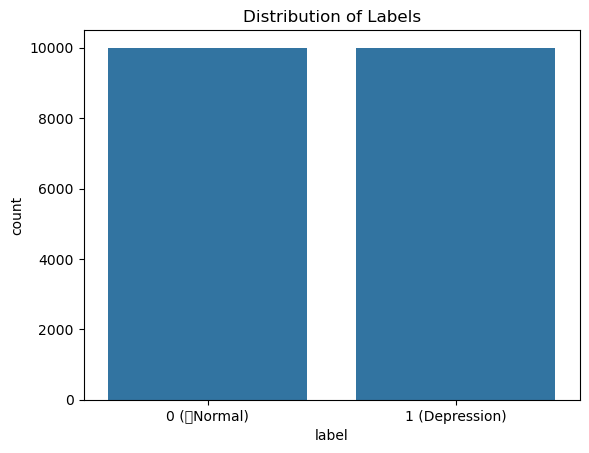

In [11]:
warnings.filterwarnings('ignore')

sns.countplot(x='label', data=df)
plt.title('Distribution of Labels')
plt.xticks(ticks=[0, 1], labels=['0 (์Normal)', '1 (Depression)'], rotation=0)
plt.show()

## ขั้นตอนที่ 3 Preprocessing & Cleaning

In [12]:
lemmatizer = WordNetLemmatizer() #โหลด lemmatization ภาษาอังกฤษจาก NLTK
stop_words = set(stopwords.words('english')) - {"no", "not", "don", "don't", "wasn't", "weren't", "isn't", "shouldn't", "wouldn't"}

# สร้าง Dictionary คำย่อ (อาจจะไม่แม่นยำ)
abbrev_map = {
    "idk": "i do not know","imo": "in my opinion","imho": "in my humble opinion","smh": "shaking my head","tbh": "to be honest",
    "btw": "by the way","omg": "oh my god","lol": "laughing out loud","lmao": "laughing my ass off","rofl": "rolling on the floor laughing",
    "brb": "be right back","bbl": "be back later","afaik": "as far as i know","fyi": "for your information","ikr": "i know right",
    "idc": "i do not care","kms": "kill myself","np": "no problem","nvm": "never mind","rn": "right now","ty": "thank you",
    "thx": "thanks","tysm": "thank you so much","yw": "you are welcome","bc": "because","bcz": "because","coz": "because",
    "cuz": "because","u": "you","ur": "your","urs": "yours","r": "are","ya": "you","plz": "please","pls": "please","thx": "thanks",
    "tho": "though","ttyl": "talk to you later","btw": "by the way","bcuz": "because","wanna": "want to","gonna": "going to",
    "gotta": "got to","kinda": "kind of","sorta": "sort of","lemme": "let me","gimme": "give me","ain't": "is not","ya'll": "you all",
    "yall": "you all","bruh": "bro","bro": "brother","omfg": "oh my fucking god","wtf": "what the fuck","wth": "what the hell","lmao": "laughing my ass off",
    "roflmao": "rolling on the floor laughing my ass off","ily": "i love you","ily2": "i love you too","oomf": "one of my friend","oomfs": "one of my friends",
    "ilyt": "i love you too","ilysm": "i love you so much","bff": "best friend forever","bf": "boyfriend","gf": "girlfriend","bae": "before anyone else",
    "oml": "oh my lord","ikr": "i know right","idc": "i do not care","imma": "i am going to","ima": "i am going to","gonna": "going to",
    "wanna": "want to","gotta": "have got to","tryna": "trying to","outta": "out of","lotta": "a lot of","kinda": "kind of",
    "sorta": "sort of","b4": "before","gr8": "great","l8r": "later","2day": "today","2moro": "tomorrow","2nite": "tonight","tmrw": "tomorrow",
    "24/7": "all the time","afk": "away from keyboard","irl": "in real life","dm": "direct message","pm": "private message","gg": "good game",
    "wp": "well played","ez": "easy","nsfw": "not safe for work","brb": "be right back","tmi": "too much information","fb": "facebook","ig": "instagram",
    "yt": "youtube","tt": "tiktok","op": "overpowered","nerf": "weaken","meta": "most effective tactic available","sus": "suspicious","fr": "for real",
    "rn": "right now","ngl": "not gonna lie","noob": "newbie","ggwp": "good game well played","asap": "as soon as possible","atm": "at the moment",
    "biz": "business","dept": "department","msg": "message","aka": "also known as","est": "established","info": "information","bc": "because",
    "faq": "frequently asked questions","lolz": "laughs","jk": "just kidding","np": "no problem","ok": "okay","okie": "okay","kk": "okay",
    "yea": "yeah","yeah": "yes","yup": "yes","nope": "no","naw": "no",
}

def expand_abbrev(text):
    return " ".join([abbrev_map.get(w, w) for w in text.split()])

# แปลง POS tag ของ nltk → รูปแบบที่ wordnet ใช้
def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, 
                "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [13]:

def clean_text(text):
    # 1. แปลงเป็นตัวพิมพ์เล็กทั้งหมด
    text = text.lower()

    # 2. ลบ RT (รีทวีต)
    text = re.sub(r'\brt\b', '', text)

    # 3. ลบ URL (http, https, www)
    text = re.sub(r'http\S+|www\S+', '', text)

    # 4. ลบ user mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # 5. ลบเครื่องหมาย # แต่เก็บคำหลัง hashtag ไว้ เช่น #happy → happy
    text = re.sub(r'#', '', text)

    # 6. ลบอักขระ non-ASCII (เช่น emoji หรือภาษาอื่น)
    text = re.sub(r"[^\x00-\x7f]", " ", text)

    # 7. ลบเครื่องหมายวรรคตอน
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 8. ลบอักขระที่ไม่ใช่ตัวอักษร (เช่น ตัวเลข หรือสัญลักษณ์พิเศษ)
    text = re.sub(r'[^a-z\s]', '', text)

    # 9. ลดตัวอักษรซ้ำ เช่น noooo → no
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # 10. ลบช่องว่างซ้ำ และตัดช่องว่างหัวท้าย
    text = re.sub(r'\s+', ' ', text).strip()

    # 11. ขยายคำย่อ (เช่น don't → do not)
    text = expand_abbrev(text)

    # 12. แยกคำ (Tokenization)
    tokens = nltk.word_tokenize(text)

    # 13. ลบ Stop Words และทำ Lemmatization (แปลงคำให้เป็นรากศัพท์)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    cleaned_tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]

    # 14. รวมคำกลับเป็นประโยค
    return " ".join(cleaned_tokens)
    

In [14]:
df['cleaned_post_text'] = df['post_text'].apply(clean_text) 

print("Original Text:", df['post_text'].iloc[0])
print()
print("Cleaned Post Text:", df['cleaned_post_text'].iloc[0])



Original Text: It's just over 2 years since I was diagnosed with #anxiety and #depression. Today I'm taking a moment to reflect on how far I've come since.

Cleaned Post Text: year since diagnose anxiety depression today im take moment reflect far ive come since


##  ขั้นตอนที่ 4 แปลงข้อความเป็นตัวเลข (Feature Extraction / Vectorization)

In [15]:
vectorizer = TfidfVectorizer(max_features=2000, min_df=5)

cleaned_post_text_tfidf = vectorizer.fit_transform(df['cleaned_post_text'])
feature_names_new_df = vectorizer.get_feature_names_out()

new_df = pd.DataFrame(cleaned_post_text_tfidf.toarray(), 
                        columns=[f"tfidf_{word}" for word in vectorizer.get_feature_names_out()])

df = pd.concat([df.reset_index(drop=True), new_df.reset_index(drop=True)], axis=1)
df = df.drop(columns=['cleaned_post_text'])
df = df.drop(columns=['post_text'])

In [16]:
df['post_created'] = pd.to_datetime(df['post_created'], format='%a %b %d %H:%M:%S %z %Y')

df['year'] = df['post_created'].dt.year
df['month'] = df['post_created'].dt.month
df['day'] = df['post_created'].dt.day
# df['minute'] = df['post_created'].dt.minute
# df['second'] = df['post_created'].dt.second
df['weekday'] = df['post_created'].dt.weekday
df['hour'] = df['post_created'].dt.hour

# สร้าง feature categorical 'time_of_day'
df['time_of_day'] = pd.cut(
    df['hour'],
    bins=[-1, 6, 12, 18, 24],
    labels=['night', 'morning', 'afternoon', 'evening']
)

le = LabelEncoder()
df['time_of_day'] = le.fit_transform(df['time_of_day'])

df = df.drop(columns=['post_created'])
df = df.drop(columns=['hour'])
df = df.drop(columns=['post_id'])
df = df.drop(columns=['user_id'])
df = df.drop(columns=['Unnamed: 0'])

In [17]:
print("New df shape:", new_df.shape)
print(new_df.head())

print("New df shape:", df.shape)
print(df.head())


New df shape: (20000, 2000)
   tfidf_ability  tfidf_able  tfidf_absolute  tfidf_absolutely  tfidf_abuse  \
0            0.0         0.0             0.0               0.0          0.0   
1            0.0         0.0             0.0               0.0          0.0   
2            0.0         0.0             0.0               0.0          0.0   
3            0.0         0.0             0.0               0.0          0.0   
4            0.0         0.0             0.0               0.0          0.0   

   tfidf_accept  tfidf_accident  tfidf_accidentally  tfidf_accomplish  \
0           0.0             0.0                 0.0               0.0   
1           0.0             0.0                 0.0               0.0   
2           0.0             0.0                 0.0               0.0   
3           0.0             0.0                 0.0               0.0   
4           0.0             0.0                 0.0               0.0   

   tfidf_account  ...  tfidf_youre  tfidf_youth  tfidf_you

## ขั้นตอนที่ 5 Feature Selection

In [18]:
# Unnamed: 0/post_id/user_id
# X = df.drop(columns=['label'])
X = new_df
y = df['label']
    
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

## ขั้นตอนที่ 6 Evaluate Model

## ------ 

In [19]:
## Logidtic + new_df

In [20]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

lasso_model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
lasso_model.fit(X_train, y_train)

# --- 2. ดึงค่าสัมประสิทธิ์ ---
coefficients = lasso_model.coef_[0]

# --- 3. สร้าง DataFrame เพื่อจัดอันดับ ---
lasso_features = pd.DataFrame({
    'feature': feature_names_new_df,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# --- 4. กรองเฉพาะตัวที่ไม่เป็นศูนย์และจัดอันดับ ---
lasso_top_features = lasso_features[lasso_features['abs_coefficient'] > 0].sort_values(
    by='abs_coefficient', ascending=False
)

print("\n--- Top Features from Lasso ---")
print(lasso_top_features.head(10)) # แสดง Top 10 (หรือน้อยกว่าถ้ามีไม่ถึง)

# 3. ประเมินผลบน Training Set เพื่อดู Overfitting
y_train_pred = lasso_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
    
# 4. ประเมินผลบน Testing Set
y_test_pred = lasso_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# ทดสอบ Loss
y_pred_proba =lasso_model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba)
y_pred = lasso_model.predict(X_test)

print(f"Accuracy on Training Set: {train_accuracy:.4f}")
print(f"Accuracy on Testing Set:  {test_accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")
print()
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


--- Top Features from Lasso ---
         feature  coefficient  abs_coefficient
1983        yong   -11.121013        11.121013
462   depression    10.394714        10.394714
1833       trump    -9.307431         9.307431
48         aleph    -7.656484         7.656484
682      foryong    -7.612679         7.612679
1107    migraine     7.453216         7.453216
914          joe    -6.896189         6.896189
1125      mnwild     6.649715         6.649715
787     headache     6.639973         6.639973
1159       nanny     6.512607         6.512607
Accuracy on Training Set: 0.7841
Accuracy on Testing Set:  0.7238
Test Loss: 0.5002

              precision    recall  f1-score   support

           0       0.71      0.76      0.73      2002
           1       0.74      0.69      0.71      1998

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000

Confusion Matrix:
 [[1518  484]
 [ 621

In [21]:
## Logidtic + df

In [22]:
# Unnamed: 0/post_id/user_id
X = df.drop(columns=['label'])
feature_names_df = X.columns.tolist()
# X = new_df
y = df['label']
    
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

lasso_model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
lasso_model.fit(X_train, y_train)

# --- 2. ดึงค่าสัมประสิทธิ์ ---
coefficients = lasso_model.coef_[0]

# --- 3. สร้าง DataFrame เพื่อจัดอันดับ ---
lasso_features = pd.DataFrame({
    'feature': feature_names_df,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
})

# --- 4. กรองเฉพาะตัวที่ไม่เป็นศูนย์และจัดอันดับ ---
lasso_top_features = lasso_features[lasso_features['abs_coefficient'] > 0].sort_values(
    by='abs_coefficient', ascending=False
)

print("\n--- Top Features from Lasso ---")
print(lasso_top_features.head(10)) # แสดง Top 10 (หรือน้อยกว่าถ้ามีไม่ถึง)

# 3. ประเมินผลบน Training Set เพื่อดู Overfitting
y_train_pred = lasso_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
    
# 4. ประเมินผลบน Testing Set
y_test_pred = lasso_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

# ทดสอบ Loss
y_pred_proba =lasso_model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba)
y_pred = lasso_model.predict(X_test)

print(f"Accuracy on Training Set: {train_accuracy:.4f}")
print(f"Accuracy on Testing Set:  {test_accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")
print()
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


--- Top Features from Lasso ---
                        feature  coefficient  abs_coefficient
1988                 tfidf_yong   -42.835383        42.835383
1913         tfidf_wearepayting   -34.833865        34.833865
1989  tfidf_yongkissreturnonpbb   -25.859092        25.859092
1794           tfidf_tilltheend   -18.284498        18.284498
512         tfidf_dreamteamyong   -16.115115        16.115115
738                tfidf_gopayt   -15.924968        15.924968
1838                tfidf_trump   -15.846460        15.846460
169                    tfidf_be   -14.016629        14.016629
1844             tfidf_tuesyong   -13.554046        13.554046
53                  tfidf_aleph   -11.492507        11.492507
Accuracy on Training Set: 0.9249
Accuracy on Testing Set:  0.9020
Test Loss: 0.2499

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1996
           1       0.88      0.93      0.90      2004

    accuracy                        

In [24]:
## ANOVA+MLP + new_df

In [25]:
# Unnamed: 0/post_id/user_id
# X = df.drop(columns=['label'])
X = new_df
y = df['label']
    
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [26]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

# ✅ ถ้า X_train เป็น DataFrame จะมีชื่อฟีเจอร์
feature_names_new_df = X_train.columns.tolist()

# --- 1. เลือกจำนวนฟีเจอร์ ---
k = 1000

# --- 2. Fit ตัวคัดเลือกฟีเจอร์ (ANOVA F-test) ---
anova_filter = SelectKBest(score_func=f_classif, k=k)
anova_filter.fit(X_train, y_train)

# --- 3. ดึงรายชื่อ Feature และคะแนน ---
selected_indices = anova_filter.get_support(indices=True)
scores = anova_filter.scores_

# กรองเฉพาะค่าที่ไม่เป็น NaN
valid = ~pd.isna(scores)
selected_indices = np.array(selected_indices)[valid[selected_indices]]

top_k_features = np.array(feature_names_new_df)[selected_indices]
scores = scores[selected_indices]

anova_top_features = pd.DataFrame({
    'feature': top_k_features,
    'f_score': scores
}).sort_values(by='f_score', ascending=False)

print(f"--- Top {min(30, k)} Features from ANOVA F-test ---")
print(anova_top_features.head(30))
print("-" * 50)

# --- 4. Transform ข้อมูล ---
X_train_sel = anova_filter.transform(X_train)
X_test_sel = anova_filter.transform(X_test)

# --- 5. สร้างและเทรนโมเดล MLP ---
clf = MLPClassifier(max_iter=500)
#MLPClassifier(max_iter= 500,alpha=0.05,hidden_layer_sizes=(5,))
clf.fit(X_train_sel, y_train)

# --- 6. ประเมินผล ---
y_train_pred = clf.predict(X_train_sel)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_sel)
test_accuracy = accuracy_score(y_test, y_test_pred)

y_pred_proba = clf.predict_proba(X_test_sel)
loss = log_loss(y_test, y_pred_proba)

print(f"--- Evaluation Results for k={k} ---")
print(f"Accuracy on Training Set: {train_accuracy:.4f}")
print(f"Accuracy on Testing Set:  {test_accuracy:.4f}")
print(f"Test Log Loss: {loss:.4f}\n")
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test, y_test_pred))


--- Top 30 Features from ANOVA F-test ---
                   feature     f_score
236       tfidf_depression  564.903537
913            tfidf_trump  271.783156
910        tfidf_treatment  231.798741
987             tfidf_yong  197.471051
624         tfidf_overcome  162.919686
333           tfidf_follow  116.988144
553         tfidf_migraine  113.182883
398            tfidf_hello  105.968744
696            tfidf_putin   96.386328
389         tfidf_headache   93.183593
391           tfidf_health   92.531396
921          tfidf_twitter   90.194202
542           tfidf_mental   88.173941
21             tfidf_aleph   85.068569
955     tfidf_wearepayting   84.280923
338          tfidf_foryong   84.280923
44           tfidf_anytime   79.927636
460              tfidf_joe   79.914694
95    tfidf_bestmusicvideo   79.491004
998             tfidf_zayn   79.318580
429     tfidf_iheartawards   77.769217
654       tfidf_pillowtalk   77.481417
869            tfidf_thank   74.779800
41           tfidf_anx

In [27]:
## ANOVA+MLP + df

In [28]:
# Unnamed: 0/post_id/user_id
X = df.drop(columns=['label'])
feature_names_df = X.columns.tolist()
# X = new_df
y = df['label']
    
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

# ✅ ถ้า X_train เป็น DataFrame จะมีชื่อฟีเจอร์
feature_names_df = X_train.columns.tolist()

# --- 1. เลือกจำนวนฟีเจอร์ ---
k = 1000

# --- 2. Fit ตัวคัดเลือกฟีเจอร์ (ANOVA F-test) ---
anova_filter = SelectKBest(score_func=f_classif, k=k)
anova_filter.fit(X_train, y_train)

# --- 3. ดึงรายชื่อ Feature และคะแนน ---
selected_indices = anova_filter.get_support(indices=True)
scores = anova_filter.scores_

# กรองเฉพาะค่าที่ไม่เป็น NaN
valid = ~pd.isna(scores)
selected_indices = np.array(selected_indices)[valid[selected_indices]]

top_k_features = np.array(feature_names_df)[selected_indices]
scores = scores[selected_indices]

anova_top_features = pd.DataFrame({
    'feature': top_k_features,
    'f_score': scores
}).sort_values(by='f_score', ascending=False)

print(f"--- Top {min(30, k)} Features from ANOVA F-test ---")
print(anova_top_features.head(30))
print("-" * 50)

# --- 4. Transform ข้อมูล ---
X_train_sel = anova_filter.transform(X_train)
X_test_sel = anova_filter.transform(X_test)

# --- 5. สร้างและเทรนโมเดล MLP ---
clf = MLPClassifier(max_iter=500)
#MLPClassifier(max_iter= 500,alpha=0.05,hidden_layer_sizes=(5,))
clf.fit(X_train_sel, y_train)

# --- 6. ประเมินผล ---
y_train_pred = clf.predict(X_train_sel)
train_accuracy = accuracy_score(y_train, y_train_pred)

y_test_pred = clf.predict(X_test_sel)
test_accuracy = accuracy_score(y_test, y_test_pred)

y_pred_proba = clf.predict_proba(X_test_sel)
loss = log_loss(y_test, y_pred_proba)

print(f"--- Evaluation Results for k={k} ---")
print(f"Accuracy on Training Set: {train_accuracy:.4f}")
print(f"Accuracy on Testing Set:  {test_accuracy:.4f}")
print(f"Test Log Loss: {loss:.4f}\n")
print("Classification Report on Test Set:")
print(classification_report(y_test, y_test_pred))
print("Confusion Matrix on Test Set:\n", confusion_matrix(y_test, y_test_pred))


--- Top 30 Features from ANOVA F-test ---
                  feature       f_score
995                  year  13845.861029
1              favourites   1047.077362
2                statuses   1018.020374
230      tfidf_depression    579.998998
904           tfidf_trump    270.146267
0                 friends    235.392696
900       tfidf_treatment    235.334285
983            tfidf_yong    214.392007
997                   day    176.506599
616        tfidf_overcome    166.535983
549        tfidf_migraine    115.414210
331          tfidf_follow    111.144172
395           tfidf_hello    102.992818
537          tfidf_mental     96.566593
683           tfidf_putin     93.243775
388          tfidf_health     92.426332
993            tfidf_zayn     92.297268
386        tfidf_headache     90.383015
23            tfidf_aleph     88.816674
92   tfidf_bestmusicvideo     87.148581
912         tfidf_twitter     86.973938
644      tfidf_pillowtalk     86.317333
421    tfidf_iheartawards     85.34291

## ---------

In [30]:

# for k in [100, 200, 500, 700, 1000, 1500, 2000]:
    
#         pipeline = Pipeline([
#             ('feature_selection', SelectKBest(f_classif, k=k)),
#             ('classification', MLPClassifier(max_iter= 500,alpha=0.05,hidden_layer_sizes=(5,))) 
#         ])
        
#         pipeline.fit(X_train, y_train)
        
#         y_train_pred = pipeline.predict(X_train)
#         train_accuracy = accuracy_score(y_train, y_train_pred)
        
#         y_test_pred = pipeline.predict(X_test)
#         test_accuracy = accuracy_score(y_test, y_test_pred)
    
#         y_pred_proba = pipeline.predict_proba(X_test)
#         loss = log_loss(y_test, y_pred_proba)
#         y_pred = pipeline.predict(X_test)
    
#         print(f"--- k={k} ---")
#         print(f"Accuracy on Training Set: {train_accuracy:.2f}")
#         print(f"Accuracy on Testing Set:  {test_accuracy:.2f}")
#         print(f"Test Loss: {loss:.4f}")
#         print()
#         print(classification_report(y_test, y_test_pred))
#         print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

In [31]:
# for k in [100, 200, 500, 700, 1000, 1500, 2000]:
# # for k in [500, 1000, 2000, 3000, 4000, 5000]:
    
#     # 1. สร้าง Pipeline ที่ประกอบด้วยตัวเลือก feature และโมเดล
#     # เราจะตั้งค่า k ในขั้นตอน SelectKBest ตรงนี้เลย
#     pipeline = Pipeline([
#         ('feature_selection', SelectKBest(f_classif, k=k)),
#         # ('classification', MultinomialNB())
#         # ('classification', LGBMClassifier())
#         # ('classification', LogisticRegression())
#         ('classification', LinearSVC(max_iter=1000)) #0.01
#         # ('classification', MLPClassifier(max_iter= 500,alpha=0.05,hidden_layer_sizes=(5,))) #0.01
#     ])
    
#     # 2. เทรน Pipeline ทั้งหมดด้วยข้อมูล Train ดั้งเดิม
#     pipeline.fit(X_train, y_train)
    
#     # 3. ประเมินผลบน Training Set เพื่อดู Overfitting
#     y_train_pred = pipeline.predict(X_train)
#     train_accuracy = accuracy_score(y_train, y_train_pred)
    
#     # 4. ประเมินผลบน Testing Set
#     y_test_pred = pipeline.predict(X_test)
#     test_accuracy = accuracy_score(y_test, y_test_pred)

#     # ทดสอบ Loss
#     # y_pred_proba = pipeline.predict_proba(X_test)
#     # loss = log_loss(y_test, y_pred_proba)
#     # y_pred = pipeline.predict(X_test)

#     print(f"--- k={k} ---")
#     print(f"Accuracy on Training Set: {train_accuracy:.2f}")
#     print(f"Accuracy on Testing Set:  {test_accuracy:.2f}")
#     print(f"Test Loss: {loss:.4f}")
#     print()
#     print(classification_report(y_test, y_test_pred))
#     print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

In [32]:
# อันนี้ใช้จริง
# from sklearn.feature_selection import SelectFpr, chi2
# features = X.columns.tolist()
# for k in [1000]:
    
#     anova_filter = SelectFpr(f_classif, alpha=0.05)
#     X_train_sel = anova_filter.fit_transform(X_train,y_train) 
#     X_test_sel = anova_filter.transform(X_test) 
#     # clf = MLPClassifier(max_iter= 500)
#     clf = MLPClassifier(max_iter= 500,alpha=0.05,hidden_layer_sizes=(5,)) #0.01
#     anova_MLP = make_pipeline(anova_filter, clf)
#     anova_MLP.fit(X_train_sel, y_train)
#     #y_pred_MLP_ANOVA = anova_MLP.predict(X_test_sel)
#     for i in anova_filter.get_support(indices=True):
#         print(f"{features[i]}", end=", ")

#     # 3. ประเมินผลบน Training Set เพื่อดู Overfitting
#     y_train_pred = anova_MLP.predict(X_train_sel)
#     train_accuracy = accuracy_score(y_train, y_train_pred)
    
#     # 4. ประเมินผลบน Testing Set
#     y_test_pred = anova_MLP.predict(X_test_sel)
#     test_accuracy = accuracy_score(y_test, y_test_pred)

#     # ทดสอบ Loss
#     y_pred_proba = anova_MLP.predict_proba(X_test_sel)
#     loss = log_loss(y_test, y_pred_proba)
#     y_pred = anova_MLP.predict(X_test_sel)

#     print(f"--- k={k} ---")
#     print(f"Accuracy on Training Set: {train_accuracy:.4f}")
#     print(f"Accuracy on Testing Set:  {test_accuracy:.4f}")
#     print(f"Test Loss: {loss:.4f}")
#     print()
#     print(classification_report(y_test, y_test_pred))
#     print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))

#     # train_sizes, train_scores, test_scores = learning_curve(
#     #     anova_MLP,
#     #     X_train, y_train,
#     #     cv=5,                     # ใช้ 5-fold cross-validation
#     #     scoring='accuracy',
#     #     n_jobs=-1,                # ใช้ทุกคอร์เพื่อความเร็ว
#     #     train_sizes=np.linspace(0.1, 1.0, 5),  # ใช้ 10% ถึง 100% ของข้อมูล
#     #     random_state=42
#     # )

#     # # คำนวณค่าเฉลี่ยและส่วนเบี่ยงเบนมาตรฐาน
#     # train_mean = np.mean(train_scores, axis=1)
#     # train_std = np.std(train_scores, axis=1)
#     # test_mean = np.mean(test_scores, axis=1)
#     # test_std = np.std(test_scores, axis=1)

#     # # ---------------------------------------------
#     # # 🔹 พล็อตกราฟ Learning Curve
#     # # ---------------------------------------------
#     # plt.figure(figsize=(8,6))
#     # plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
#     # plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validation score')

#     # # พล็อตแถบความไม่แน่นอน (standard deviation)
#     # plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
#     # plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)

#     # plt.title(f"Learning Curve (MLP + ANOVA, k={k})")
#     # plt.xlabel("Training examples")
#     # plt.ylabel("Accuracy")
#     # plt.legend(loc="best")
#     # plt.ylim(None, 1.01) 
#     # plt.grid(True)
#     # plt.show()

In [33]:
# confusion matrix
# cm = confusion_matrix(y_test, y_pred)
 
# # display confusion matrix
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot(cmap=plt.cm.Blues)

# plt.title("Confusion Matrix - MLP")
# plt.show()

In [34]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.pipeline import Pipeline
# from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.neural_network import MLPClassifier
# from sklearn.metrics import accuracy_score, f1_score, log_loss
# from sklearn.model_selection import learning_curve
# import seaborn as sns

# BEST_K = 1000
# print(f"\n--- Generating Learning Curve for k={BEST_K} ---")

# final_pipeline = Pipeline([
#             ('feature_selection', SelectKBest(f_classif, k=BEST_K)),
#             ('classification', MLPClassifier(max_iter= 500,alpha=0.05,hidden_layer_sizes=(5,))) 
# ])

# train_sizes_abs, train_scores, test_scores = learning_curve(
#     estimator=final_pipeline,
#     X=X_train,  # ใช้ข้อมูล Train ทั้งหมด, ฟังก์ชันจะแบ่งให้เอง
#     y=y_train,
#     train_sizes=np.linspace(0.1, 1.0, 10), # แบ่งเป็น 10 ช่วง ตั้งแต่ 10% - 100%
#     cv=5,            # จำนวน Cross-validation folds (5-fold)
#     scoring='accuracy', # f1 ธรรม เหมาะกับ Binary Classification (โจทย์มี 2 คลาส)
#     n_jobs=-1,        # ใช้ CPU ทุก core เพื่อความเร็ว
# )

# # 3. คำนวณค่าเฉลี่ยและค่าเบี่ยงเบนมาตรฐานของคะแนน
# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# # 4. พล็อตกราฟ Learning Curve
# sns.set_style("whitegrid")
# plt.figure(figsize=(10, 6))

# plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# # เพิ่มแถบ Standard Deviation เพื่อดูความแปรปรวนของคะแนน
# plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plt.title(f"Learning Curve for MLPClassifier (k={BEST_K})")
# plt.xlabel("Number of Training Samples")
# plt.ylabel("Accuracy Score")
# plt.legend(loc="best")
# plt.ylim(None, 1.01) # ตั้งค่าแกน Y ให้สูงสุดที่ 1.01 เพื่อให้สวยงาม
# plt.show()